# Sentiment Analysis using the IMDb reviews dataset - RNN-based model with attention/transformers mechanisms

Ref.

Kaggle

[Sentiment Analysis of IMDB Movie Reviews - gold](https://www.kaggle.com/code/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews)

[Sentiment Analysis of IMDB Movie Reviews - cooper](https://www.kaggle.com/code/bhavikjikadara/sentiment-analysis-of-imdb-movie-reviews)

[IMDB Dataset Sentiment Analysis using RNN](https://www.kaggle.com/code/tanyildizderya/imdb-dataset-sentiment-analysis-using-rnn)

Keras

[Keras - IMDB movie review sentiment classification dataset](https://keras.io/api/datasets/imdb/)

這是一個包含 25,000 部電影評論的 IMDB 數據集，按情感（正面/負面）進行標記。評論已經過預處理，每個評論都被編碼為一個詞索引列表（整數）。為了方便起見，詞彙按照數據集中的整體頻率進行索引，因此例如整數 "3" 編碼了數據中第三個最常見的詞。這使得可以快速進行過濾操作，例如："只考慮前 10,000 個最常見的詞，但排除前 20 個最常見的詞"。

按照慣例，"0" 不代表特定的詞，而是用於編碼填充標記。

Benchmark

[Sentiment Analysis on IMDb](https://paperswithcode.com/sota/sentiment-analysis-on-imdb)

In [44]:
# Python version: 3.10.6

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from sklearn import metrics
import numpy as np
import pandas as pd

import keras
from keras import layers, losses, optimizers
from keras_preprocessing.sequence import pad_sequences
from keras.datasets import imdb
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback

tf.config.list_physical_devices("GPU")

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6818766024113099047
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 18478489396
locality {
  bus_id: 1
}
incarnation: 42060819539346384
physical_device_desc: "device: 0, name: DML, pci bus id: <undefined>"
xla_global_id: -1
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 15569762240
locality {
  bus_id: 1
}
incarnation: 8183800301593619366
physical_device_desc: "device: 1, name: DML, pci bus id: <undefined>"
xla_global_id: -1
]


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [45]:
# sequence preprocessing parameters
start_char = 1
oov_char = 2
index_from = 3
max_num_words = 5000
max_sequence_length = 240

# training parameters
training = True
num_epochs = 20
batch_size = 512
validation_split = 0.1
learning_rate = 0.001

## Load dataset

In [46]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(
    num_words=max_num_words,
    skip_top=0,
    maxlen=None,
    seed=113,
    start_char=start_char,
    oov_char=oov_char,
    index_from=index_from,
)

## EDA

In [47]:
print("Training data shape:", x_train.shape)
print("Training label shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test label shape:", y_test.shape)

Training data shape: (25000,)
Training label shape: (25000,)
Test data shape: (25000,)
Test label shape: (25000,)


In [48]:
unique, counts = np.unique(y_train, return_counts=True)
print("y train distribution: ", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("y test distribution: ", dict(zip(unique, counts)))

y train distribution:  {0: 12500, 1: 12500}
y test distribution:  {0: 12500, 1: 12500}


In [49]:
def print_decoded_sequence(data, index=0):
    # 取得字典 mapping => { word: index ...}
    word_index = imdb.get_word_index()

    # key, value => word, index
    inverted_word_index = dict((index + index_from, word) for (word, index) in word_index.items())

    # Update `inverted_word_index` to include `start_char` and `oov_char`
    inverted_word_index[0] = "[MASK]"
    inverted_word_index[start_char] = "[START]"
    inverted_word_index[oov_char] = "[OOV]"

    # X data (word sequence)

    print(data[index])
    decoded_sequence = " ".join(inverted_word_index[i] for i in data[index])
    print(decoded_sequence)

    # y data (labels: positive or negative)

    print(y_train[index])

In [50]:
print_decoded_sequence(x_train)

[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[START] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] the [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] the [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] the [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] the [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OO

Text(0.5, 1.0, 'y train')

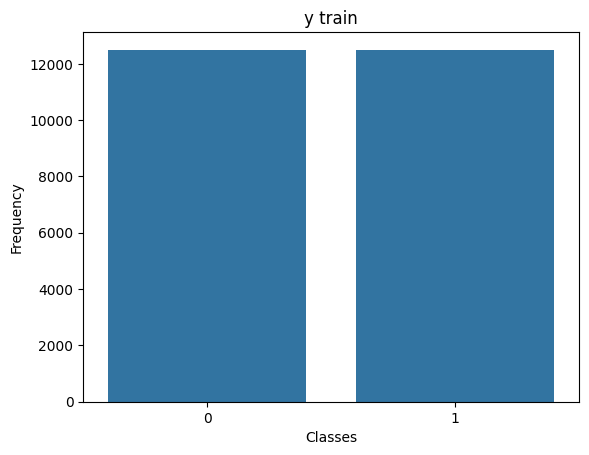

In [51]:
# training label distribution

plt.figure()
sns.countplot(pd.DataFrame(y_train, columns=["class"]), x="class")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("y train")

Text(0.5, 1.0, 'y test')

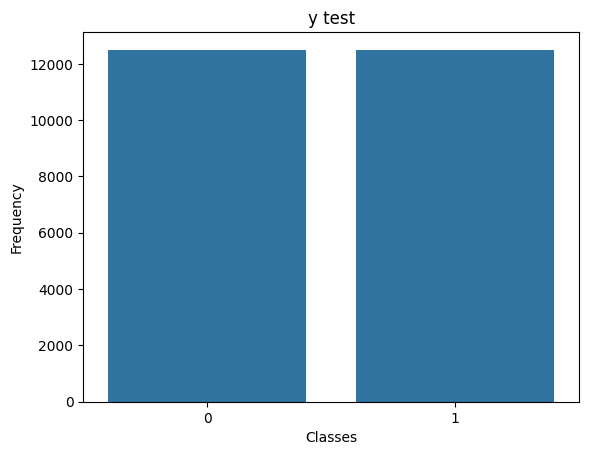

In [52]:
# test label distribution

plt.figure()
sns.countplot(pd.DataFrame(y_test, columns=["class"]), x="class")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("y test")

In [53]:
# words distribution


def visualize_sequence_distribution(x_train, x_test):
    review_len_train = []
    review_len_test = []
    for i, j in zip(x_train, x_test):
        review_len_train.append(len(i))
        review_len_test.append(len(j))

    print("min:", min(review_len_train), "max:", max(review_len_train))
    print("min:", min(review_len_test), "max:", max(review_len_test))

    sns.displot(review_len_train, rug_kws={"alpha": 0.3})
    plt.xlabel("review length")
    plt.title("review train")
    sns.displot(review_len_test, rug_kws={"alpha": 0.3})
    plt.xlabel("review length")
    plt.title("review test")

min: 11 max: 2494
min: 7 max: 2315


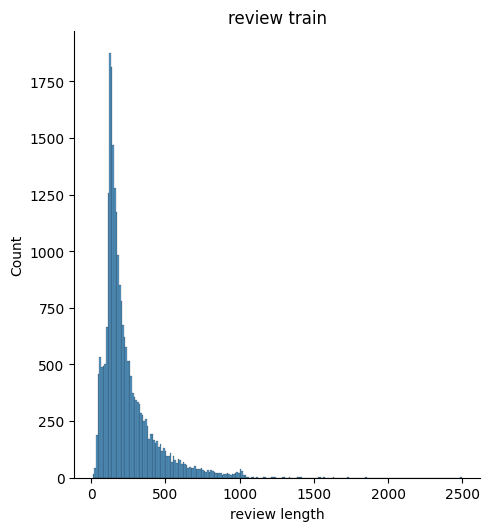

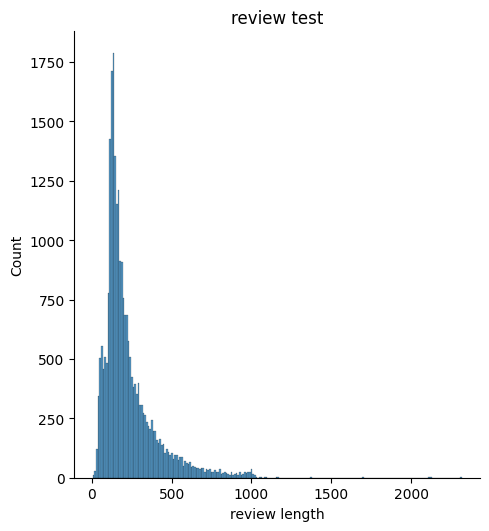

In [54]:
visualize_sequence_distribution(x_train, x_test)

In [55]:
mean_sequence_len = np.mean([len(seq) for seq in x_train])
mean_sequence_len

238.71364

## Data preprocessing

Keras's IMDB

X data : 資料已經預處理過，包括
* normalization => setting English stopwords
* removing html strips and noise text
* removing special characters
* segmentation (斷詞)
* removing stopwords
* encoding (編碼)

y data : 代表正向 (positive) 或負向 (negative) 的評論

In [56]:
# 使每個 sequence 有相同的長度

x_train = pad_sequences(x_train, maxlen=max_sequence_length)
x_test = pad_sequences(x_test, maxlen=max_sequence_length)

In [57]:
print("Training data shape:", x_train.shape)
print("Training label shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test label shape:", y_test.shape)

Training data shape: (25000, 5)
Training label shape: (25000,)
Test data shape: (25000, 5)
Test label shape: (25000,)


min: 5 max: 5
min: 5 max: 5


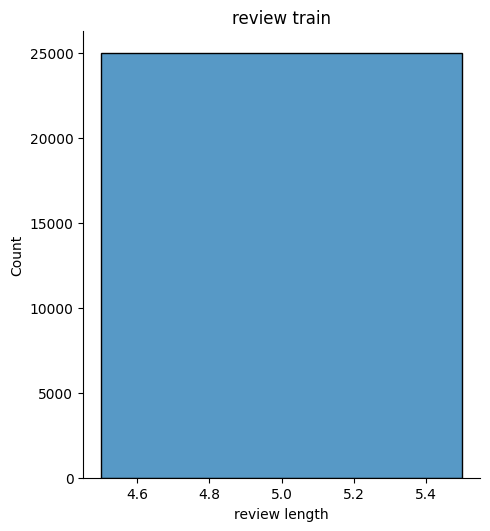

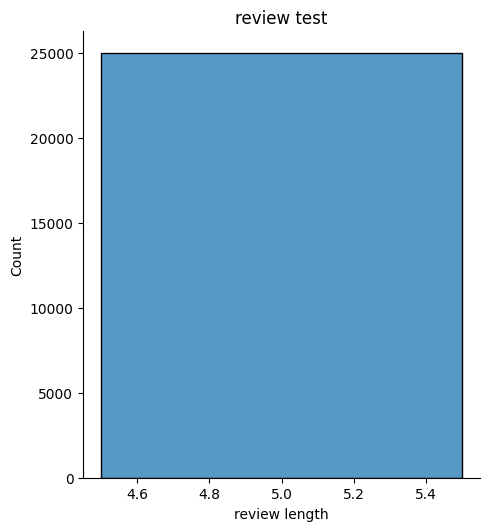

In [58]:
visualize_sequence_distribution(x_train, x_test)

In [59]:
print_decoded_sequence(x_train)

[2 2 2 2 2]
[OOV] [OOV] [OOV] [OOV] [OOV]
1


## RNN mechanism

Ref.

[一文搞懂RNN（循环神经网络）基础篇](https://zhuanlan.zhihu.com/p/30844905)

![rnn](./images/rnn.png)

S<sub>t</sub> 代表神經元在 t 時刻上，同時接收
* 輸入 X 與其輸入權重 U
* 前一次 S 在 t-1 時刻的 S<sub>t-1</sub> 與其 W (S<sub>t-1</sub> --> S<sub>t</sub> 的權重)

展開

![rnn-expand](./images/rnn-expand.png)

## Attention mechanism

Ref.

[完全解析RNN, Seq2Seq, Attention注意力机制](https://zhuanlan.zhihu.com/p/51383402)

[A simple overview of RNN, LSTM and Attention Mechanism](https://medium.com/swlh/a-simple-overview-of-rnn-lstm-and-attention-mechanism-9e844763d07b)

[注意力機制 (Attention Mechanism) 的理解與實作](https://www.kaggle.com/code/lianghsunhuang/attention-mechanism)

Attention 的架構

![attention-mechanism](./images/attention-mechanism.png)

## Build model

Ref.

[Keras 中的循环神经网络 (RNN)](https://tensorflow.google.cn/guide/keras/rnn?hl=zh-cn)

[Keras实现CNN、RNN（基于attention 的双向RNN）及两者的融合](https://blog.csdn.net/xwd18280820053/article/details/80060544)

[Text classification with an RNN](https://www.tensorflow.org/text/tutorials/text_classification_rnn)

[用LSTM模型分類IMDB電影資料集評論](https://dysonma.github.io/2020/11/21/LSTM_IMDB/)

In [60]:
class BidirectionalRnn(keras.Model):

    def __init__(self, **kwargs):

        super(BidirectionalRnn, self).__init__()

        self.embedding_1 = layers.Embedding(max_num_words, 256, mask_zero=True)
        self.dropout_1 = layers.Dropout(0.2)
        self.first_rnn = layers.Bidirectional(layers.LSTM(128, activation="tanh", return_sequences=True))
        self.second_rnn = layers.Bidirectional(layers.LSTM(128, activation="tanh", return_sequences=False))
        self.dense_1 = layers.Dense(256, activation="relu")
        self.final_output = tf.keras.layers.Dense(1, activation="sigmoid")

    def call(self, inputs, training=False):
        x = self.embedding_1(inputs, training=training)
        x = self.dropout_1(x)
        x = self.first_rnn(x, training=training)
        x = self.second_rnn(x, training=training)
        x = self.dense_1(x, training=training)
        x = self.final_output(x, training=training)
        return x

## Preview model

In [61]:
rnn = BidirectionalRnn()
rnn.build(input_shape=(None, max_sequence_length))
rnn.call(layers.Input((max_sequence_length)))
rnn.summary()

Model: "bidirectional_rnn_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 5, 256)            1280      
                                                                 
 dropout_2 (Dropout)         (None, 5, 256)            0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 5, 256)           98560     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 256)              98560     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 1)         

In [62]:
rnn.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    metrics=["accuracy"],
)

## Train model

In [63]:
train_history = rnn.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    verbose=0,
    batch_size=batch_size,
    validation_split=validation_split,
    callbacks=[TqdmCallback(verbose=0)],
)

0epoch [00:00, ?epoch/s]

## Evaluation

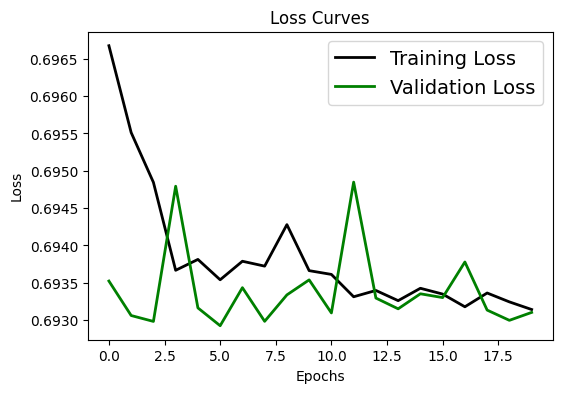

In [64]:
if training:
    plt.figure(figsize=[6, 4])
    plt.plot(train_history.history["loss"], "black", linewidth=2.0)
    plt.plot(train_history.history["val_loss"], "green", linewidth=2.0)
    plt.legend(["Training Loss", "Validation Loss"], fontsize=14)
    plt.xlabel("Epochs", fontsize=10)
    plt.ylabel("Loss", fontsize=10)
    plt.title("Loss Curves", fontsize=12)

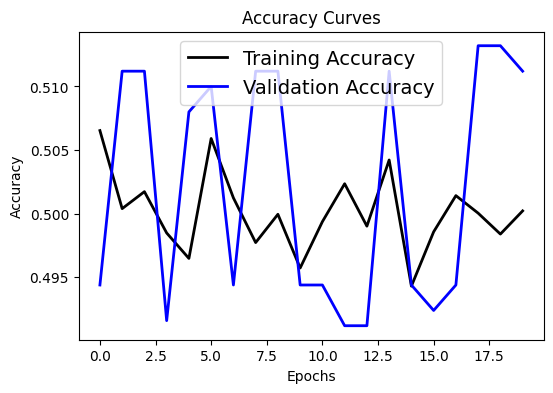

In [65]:
if training:
    plt.figure(figsize=[6, 4])
    plt.plot(train_history.history["accuracy"], "black", linewidth=2.0)
    plt.plot(train_history.history["val_accuracy"], "blue", linewidth=2.0)
    plt.legend(["Training Accuracy", "Validation Accuracy"], fontsize=14)
    plt.xlabel("Epochs", fontsize=10)
    plt.ylabel("Accuracy", fontsize=10)
    plt.title("Accuracy Curves", fontsize=12)

In [66]:
if not training:
    test_result = rnn.evaluate(x_test, y_test, batch_size=batch_size)

## Save result

## Final prediction

## Test result insights